In [1]:
from fastai.vision import *
from bs4 import BeautifulSoup
import requests
import re
from urllib.request import urlopen
import urllib.request
import os
import json
import pandas as pd
import csv
import math

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt

# 1. get the url 

In [600]:
# create a folder called "Pictures" at the current directory

In [6]:
def get_soup(url,header):
    return BeautifulSoup(urlopen(urllib.request.Request(url,headers=header)),'html.parser')

query = input("query image:")# you can change the query for the image  here
image_type="ActiOn"
query= query.split()
query='+'.join(query)
url="https://www.google.co.in/search?q="+query+"&source=lnms&tbm=isch"

DIR="Pictures"

header={'User-Agent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36"
}
soup = get_soup(url,header)

ActualImages=[]# contains the link for Large original images, type of  image
for a in soup.find_all("div",{"class":"rg_meta"}):
    link , Type =json.loads(a.text)["ou"]  ,json.loads(a.text)["ity"]
    ActualImages.append(link)

print("there are total", len(ActualImages),"images")


file_name = query.replace("+","_")
if not os.path.exists(DIR):
            os.mkdir(DIR)

# with open(DIR+'/'+file_name+'.csv', 'w') as writeFile:
#     writer = csv.writer(writeFile, dialect='excel')
#     writer.writerow(ActualImages)

df = pd.DataFrame({'data':ActualImages})
df.to_csv(DIR+'/'+file_name+'.csv', header=False)

print("done")

query image:hairstyle
there are total 100 images
done


# 2. create folders and download images

In [3]:
PATH = Path("")

In [8]:
# create folders
def create_folder(obj):
    folder = obj
    file = obj+'.csv'
    dest = PATH/folder
    dest.mkdir(parents=True, exist_ok=True)

In [9]:
# three categories
classes = ['car','dress','hairstyle']
folders = ['car','dress','hairstyle']
files = ['car.csv','dress.csv','hairstyle.csv']

In [10]:
for item in classes:
    create_folder(item)

# 3. Move the csv to the corresponding folder
### in terminal

#### (for each categrory)  
#### (because i need each csv doesn't have the first column which is integers from 1 to n)
(MSDS694) appledeMacBook-Pro-4:AorB Reagan$ cd Pictures/  

(MSDS694) appledeMacBook-Pro-4:Pictures Reagan$ chmod +x ../del_first_col.sh   

(MSDS694) appledeMacBook-Pro-4:Pictures Reagan$ ../del_first_col.sh

# 4.Download pictures

In [11]:
for i in range(len(classes)):
    path = Path('')
    folder = folders[i]
    file = files[i]
    dest = path/folder
    download_images(path/folder/file, dest, max_pics=100, max_workers=0)

Error "https://media.wired.com/photos/59bafdf204afdc5248726f5c/master/w_2400 No connection adapters were found for '"https://media.wired.com/photos/59bafdf204afdc5248726f5c/master/w_2400'
Error "https://www.popsci.com/sites/popsci.com/files/styles/1000_1x_/public/images/2018/03/senna.jpg?itok=eYNPMGjA&fc=50 No connection adapters were found for '"https://www.popsci.com/sites/popsci.com/files/styles/1000_1x_/public/images/2018/03/senna.jpg?itok=eYNPMGjA&fc=50'
Error "https://img.etimg.com/thumb/msid-61740239 No connection adapters were found for '"https://img.etimg.com/thumb/msid-61740239'
Error "https://www.popsci.com/sites/popsci.com/files/styles/1000_1x_/public/images/2018/08/01-1953-bmw-isetta.jpg?itok=xy0USI9H&fc=50 No connection adapters were found for '"https://www.popsci.com/sites/popsci.com/files/styles/1000_1x_/public/images/2018/08/01-1953-bmw-isetta.jpg?itok=xy0USI9H&fc=50'
Error "https://m.media-amazon.com/images/M/MV5BMzMwYWZkZjctZTU5Ny00MDNiLTlkMmYtNzkyODMwMGUxYzA2XkEyXkF

In [313]:
# folder = 'car'
# file = 'car.csv'
# path = Path('')
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [12]:
path.ls()

[PosixPath('.DS_Store'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('all.sh'),
 PosixPath('Apr1st.ipynb'),
 PosixPath('Apr2nd.ipynb'),
 PosixPath('Apr3rd.ipynb'),
 PosixPath('car'),
 PosixPath('del_first_col.sh'),
 PosixPath('dress'),
 PosixPath('hairstyle'),
 PosixPath('Mar30th.ipynb'),
 PosixPath('mode_tmp.pth'),
 PosixPath('Pictures'),
 PosixPath('search_terms.py')]

### 4.2 rename image filenames

In [13]:
def rename_image(obj):
    for filename in os.listdir(PATH/obj): 
        path = PATH/obj
        dst = os.path.join(path,obj + filename)
        src = os.path.join(path,filename)

        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 

In [14]:
for item in classes:
    rename_image(item)

# 5. read image 

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(628, 1200, 3)

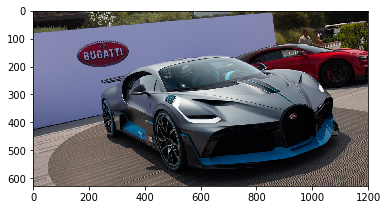

In [5]:
# try read one image 
path = PATH/"car/car00000020.jpg"
im = read_image(path)
plt.imshow(im)
im.shape

In [6]:
im = cv2.imread(str(path))
im.shape

(628, 1200, 3)

# 6.Resize images

### 6.1 functions

In [7]:
import math
def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [8]:
# resize images
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def resize_crop_image(path, sz=(303, 227)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

def resize_all_images(resize_path, org_path):
#     files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    files = [x for x in list(org_path.iterdir()) if x.suffix != ".csv"]
    for f in files:
        try:
            f_name = f.parts[-1]    
            new_path = resize_path/f_name

            im = resize_crop_image(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
        except:
            pass

### 6.2 create folders for resized images 

In [22]:
def create_resized_folder(obj):
    folder = "resized_"+ obj
    dest = PATH/folder
    dest.mkdir(parents=True, exist_ok=True)

In [23]:
# empty folders
for item in classes:
    create_resized_folder(item)

In [24]:
# resize images from original folder to new folder
resize_all_images(PATH/"resized_car", PATH/"car")
resize_all_images(PATH/"resized_dress", PATH/"dress")
resize_all_images(PATH/"resized_hairstyle", PATH/"hairstyle")


### 6.3 create a folder to put in all the images (in order)

#### in terminal
appledeMBP-4:Pictures Reagan$ chmod +x all.sh  

appledeMBP-4:Pictures Reagan$ ../all.sh

# 7.split training set and validation set

In [ ]:
# create datasets together 

In [25]:
filenames = os.listdir(PATH/"all")
filenames.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(filenames)

split_1 = int(0.8 * len(filenames))
split_2 = int(0.95 * len(filenames))

train_filenames = filenames[:split_1]
val_filenames = filenames[split_1:split_2]
test_filenames = filenames[split_2:]

In [26]:
import os
import shutil
import glob

source=PATH/'all'
dest1=PATH/'train'
dest2=PATH/'val'
dest3=PATH/'test'

for file in train_filenames:
    fu = os.path.join(source, file)
    shutil.copy(fu, dest1)
    
for file in val_filenames:
    fu = os.path.join(source, file)
    shutil.copy(fu, dest2)
    
for file in test_filenames:
    fu = os.path.join(source, file)
    shutil.copy(fu, dest3)

In [12]:
train_label_text = []
val_label_text = []
test_label_text = []

for item in os.listdir(PATH/"train"):
    train_label_text.append(item.split('0')[0])
for item in os.listdir(PATH/"val"):
    val_label_text.append(item.split('0')[0])
for item in os.listdir(PATH/"test"):
    test_label_text.append(item.split('0')[0])

In [13]:
dictionary = {'car':0, 'dress':1, 'hairstyle':2}

In [14]:
train_label = [dictionary[item] for item in train_label_text]
val_label = [dictionary[item] for item in val_label_text]
test_label = [dictionary[item] for item in test_label_text]

In [15]:
# do not run the above multiple times. 
print(len(val_label)+len(train_label))
print(len(os.listdir(PATH/"all")))
print(len(os.listdir(PATH/"train"))+len(os.listdir(PATH/"val")))

255
269
255


# 8.modeling

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]
def apply_transforms(x, sz=(303, 227), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = rotate_cv(x, np.random.uniform(-10,10))
    x = random_crop(x, sz[1], sz[0])
    if np.random.rand() >= .5:
                x = np.fliplr(x).copy()
    return x

In [17]:
class imageDataset(Dataset):
    def __init__(self, files_path, labels, transform=False):
        self.num_files = len(labels)
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
#         row = self.labels.iloc[index,:]
#         y = row["invasive"]
        y = self.labels[index]
        file_name =os.listdir(self.files_path)[index]
        path = self.files_path/str(file_name)
        x = read_image(path)
        if self.transform:
            x = apply_transforms(x)
        #else:
        #    x = cv2.resize(x, (303, 227))
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y

### 8.2 use imageDataset() 

In [18]:
train_ds = imageDataset(PATH/"train", labels=train_label)
val_ds = imageDataset(PATH/"val", labels=val_label)
test_ds = imageDataset(PATH/"test", labels=test_label)

In [19]:
# train_loader, valid_loader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)
test_loader = DataLoader(test_ds, num_workers=2)

In [20]:
# train_dl, val_dl
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds)

### 8.3 the model

In [21]:
resnet = models.resnet34(pretrained=True)

In [22]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 5)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [24]:
model = Net()

In [25]:
x, y = next(iter(train_dl))

In [26]:
x = x.float()
y = y.float()
y.shape

torch.Size([64])

In [52]:
# ???
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 8, 10])

In [53]:
# ???
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [54]:
# ???
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [27]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 5])

## loss

In [28]:
F.cross_entropy(y_hat,y.long()).item()

1.61969792842865

### 8.4 learning rate finder

In [29]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [62]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)

def load_model(m, p): 
    m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=4):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.float()
            y = y.float()
            out = model(x)
            #loss = F.binary_cross_entropy_with_logits(out, y)
            #loss = F.cross_entropy(out,torch.max(y, 1)[1])
            loss = F.cross_entropy(out,y.long())
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [63]:
model = Net()
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-6, lr_high=0.1)

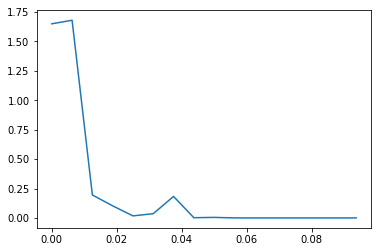

In [64]:
plt.plot(lrs, losses)
plt.show()

In [129]:
#maybe we should choose lr = 0.015

# 9.Feed Forward NN

In [30]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            #images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images.float())
            loss = F.cross_entropy(outputs, labels.float().long())
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [31]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.float())
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels.float().long())
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [32]:
net = Net()  # net is the model
learning_rate = 0.015
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# model_accuracy_loss(net, val_loader)

In [33]:
train_model(train_loader, val_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.5737
Epoch [1/2], Valid Accuracy: 62.5000, Valid Loss: 1.7707
Epoch [2/2], Loss: 0.6708
Epoch [2/2], Valid Accuracy: 95.0000, Valid Loss: 0.0909


(95.0, 0.09093298017978668, 0.6708076010393196)

# 10.test on test_loader 

In [34]:
model_accuracy_loss(net, test_loader)  # our model is net

(100.0, 0.008837785039629256)

In [35]:
for images, labels in test_loader:
    outputs = net(images.float())
    _, pred = torch.max(outputs.data, 1)
    print("predict:{}".format(pred))
    print("true_label:{}".format(labels))
    print("----------------")

predict:tensor([0])
true_label:tensor([0])
----------------
predict:tensor([0])
true_label:tensor([0])
----------------
predict:tensor([0])
true_label:tensor([0])
----------------
predict:tensor([0])
true_label:tensor([0])
----------------
predict:tensor([0])
true_label:tensor([0])
----------------
predict:tensor([1])
true_label:tensor([1])
----------------
predict:tensor([1])
true_label:tensor([1])
----------------
predict:tensor([1])
true_label:tensor([1])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------
predict:tensor([2])
true_label:tensor([2])
----------------


In [37]:
def save_model(m, p): torch.save(m.state_dict(), p)

In [38]:
p = PATH/"model.pth"
save_model(net, p)

In [39]:
!ls

Apr1st.ipynb      all               hairstyle         resized_hairstyle
Apr2nd.ipynb      all.sh            mode_tmp.pth      search_terms.py
Apr3rd.ipynb      car               model.pth         test
Mar30th.ipynb     del_first_col.sh  resized_car       train
Pictures          dress             resized_dress     val


In [40]:
!ls -lhrt

total 338880
-rw-r--r--@   1 Reagan  staff   1.3K Mar 29 21:00 search_terms.py
-rw-r--r--@   1 Reagan  staff   181K Mar 30 23:13 Mar30th.ipynb
-rw-r--r--@   1 Reagan  staff   201K Apr  2 19:24 Apr1st.ipynb
-rwxr-xr-x@   1 Reagan  staff   566B Apr  2 19:27 del_first_col.sh
-rw-r--r--@   1 Reagan  staff   220K Apr  2 22:40 Apr2nd.ipynb
drwxr-xr-x@   3 Reagan  staff   102B Apr  3 11:23 Pictures
drwxr-xr-x@  96 Reagan  staff   3.2K Apr  3 11:26 hairstyle
drwxr-xr-x@  95 Reagan  staff   3.2K Apr  3 11:26 dress
drwxr-xr-x@  94 Reagan  staff   3.1K Apr  3 11:26 car
drwxr-xr-x@  89 Reagan  staff   3.0K Apr  3 11:26 resized_car
drwxr-xr-x@  94 Reagan  staff   3.1K Apr  3 11:26 resized_dress
drwxr-xr-x@  92 Reagan  staff   3.1K Apr  3 11:26 resized_hairstyle
drwxr-xr-x@ 271 Reagan  staff   9.0K Apr  3 11:28 all
-rwxr-xr-x@   1 Reagan  staff   199B Apr  3 11:29 all.sh
drwxr-xr-x@  42 Reagan  staff   1.4K Apr  3 11:29 val
drwxr-xr-x@ 217 Reagan  staff   7.2K Apr  3 11:29 train
drwxr-xr-x@  16 Reag